The goal of this notebook is to generate data for our experiments.

The generated data will have:
* correlated and uncorrelated normally distributed variables
* categorical variables
* ordinal variables
* different scales

With this data, we will create specific target variables, obtained both by linear and non-linear relationships by using
* All the variables
* Only the uncorrelated
* Only the correlated
* Only 3 variables

Moreover, we will also make these data dirtier (after creating the target variables) by
* adding random noise
* removing random entries (or random entries based on categories)
* adding outliers

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import random
import pickle

import source.explore as exp

%matplotlib inline
pd.set_option('max_columns', 500)
np.random.seed(23)
random.seed(23)

# Data generation

In [2]:
def make_uncorrelated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # normal distributions
    df['unc_normal_1'] = np.random.normal(loc=0, scale=0.5, size=n_entries)
    df['unc_normal_2'] = np.random.normal(loc=10, scale=1, size=n_entries)
    # Skewed distribution
    df['unc_skewed_pos'] = np.expm1(np.random.normal(loc=1.3, scale=0.5, size=n_entries))
    df['unc_skewed_neg'] = 40 - np.expm1(np.random.normal(loc=2.3, scale=0.3, size=n_entries))
    
    # categorical variables
    df['unc_binary'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['unc_categories_5'] = np.random.choice(['a', 'b', 'c', 'd', 'e'], size=(n_entries,), p=[2/5, 1/5, 1/10, 3/15, 1/10])
    i = 0
    random_cats = []
    # generate 100 random strings of 3 categories
    while i < 100:
        random_cats.append(''.join([random.choice(string.ascii_lowercase) for _ in range(3)]))
        i += 1
    df['unc_categories_100'] = np.random.choice(random_cats, size=(n_entries,))
    
    df['unc_ordinal'] = np.random.choice(np.arange(1,100), size=(n_entries,))
    
    return df


def make_correlated(data, n_entries):
    df = data.copy()
    np.random.seed(23)
    random.seed(23)
    # correlation with 1 category
    df['corr_cat_1'] = np.random.choice([0, 1], size=(n_entries,), p=[1/3, 2/3])
    df['corr_cat_2'] = np.random.choice([0, 1], size=(n_entries,))
    df.loc[df.corr_cat_1 == 0, 'corr_normal_by_cat'] = np.random.normal(loc=-0.5, scale=0.4, size=n_entries - df.corr_cat_1.sum())
    df.loc[df.corr_cat_1 == 1, 'corr_normal_by_cat'] = np.random.normal(loc=1, scale=0.2, size=df.corr_cat_1.sum())
    
    # correlation with 2 categories
    tmp = df.groupby(['corr_cat_1', 'corr_cat_2']).size()
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=2, scale=0.4, size=tmp[0][0])
    df.loc[(df.corr_cat_1 == 0) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=4, scale=0.65, size=tmp[0][1])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 0) , 'corr_normal_by_2cats'] = np.random.normal(loc=1, scale=1, size=tmp[1][0])
    df.loc[(df.corr_cat_1 == 1) & (df.corr_cat_2 == 1) , 'corr_normal_by_2cats'] = np.random.normal(loc=-1, scale=0.5, size=tmp[1][1])
    
    # multinormals with different correlations
    df['corr_multinormal_high_a'] = 0
    df['corr_multinormal_high_b'] = 0
    df[['corr_multinormal_high_a', 'corr_multinormal_high_b']] = np.random.multivariate_normal(mean=[6, -2], cov=[[2, -0.8], [-0.8, 0.5]], size=n_entries)
    
    df['corr_multinormal_mid_a'] = 0
    df['corr_multinormal_mid_b'] = 0
    df[['corr_multinormal_mid_a', 'corr_multinormal_mid_b']] = np.random.multivariate_normal(mean=[20, 11], cov=[[7, 2.9], [2.9, 5]], size=n_entries)
    
    df['corr_multinormal_low_a'] = 0
    df['corr_multinormal_low_b'] = 0
    df[['corr_multinormal_low_a', 'corr_multinormal_low_b']] = np.random.multivariate_normal(mean=[-6, 4], cov=[[1, 0.3], [0.3, 2]], size=n_entries)
    
    return df

In [3]:
data = pd.DataFrame()

data = make_uncorrelated(data, 100000)
data = make_correlated(data, 100000)

data.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,25.236371,11.646659,-5.525505,4.621740
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,20.909618,11.555425,-5.988788,2.057060
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,21.466997,11.038788,-5.470228,5.952688
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,21.905036,9.963264,-5.431880,3.758482
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.377266,6.832519,-8.288617,3.684319


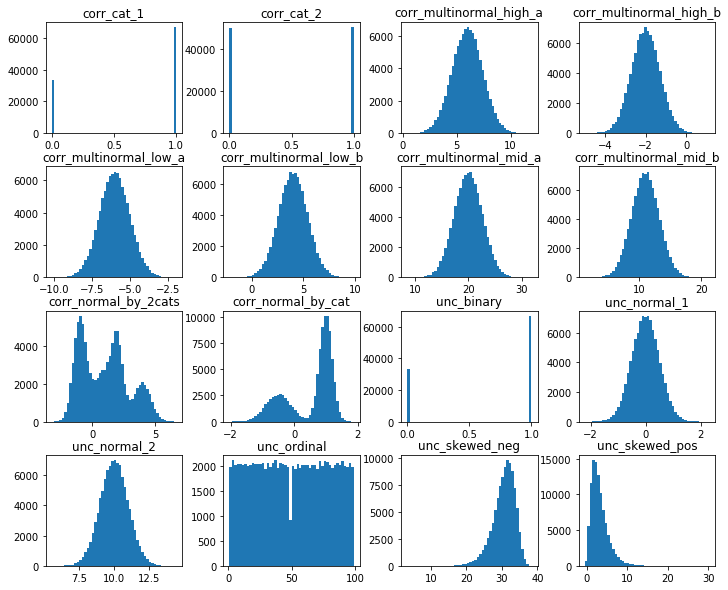

In [4]:
data.hist(bins=50, figsize=(12,10), grid=False)
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
unc_normal_1               100000 non-null float64
unc_normal_2               100000 non-null float64
unc_skewed_pos             100000 non-null float64
unc_skewed_neg             100000 non-null float64
unc_binary                 100000 non-null int64
unc_categories_5           100000 non-null object
unc_categories_100         100000 non-null object
unc_ordinal                100000 non-null int64
corr_cat_1                 100000 non-null int64
corr_cat_2                 100000 non-null int64
corr_normal_by_cat         100000 non-null float64
corr_normal_by_2cats       100000 non-null float64
corr_multinormal_high_a    100000 non-null float64
corr_multinormal_high_b    100000 non-null float64
corr_multinormal_mid_a     100000 non-null float64
corr_multinormal_mid_b     100000 non-null float64
corr_multinormal_low_a     100000 non-null float64
corr_multinormal_low_b     100000

In [6]:
data.describe(include='all').fillna('-')

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,-,-,-,-,-,5,100,-,-,-,-,-,-,-,-,-,-,-
top,-,-,-,-,-,a,fao,-,-,-,-,-,-,-,-,-,-,-
freq,-,-,-,-,-,39976,1070,-,-,-,-,-,-,-,-,-,-,-
mean,-0.00353272,9.99797,3.15068,30.5588,0.66704,-,-,49.9657,0.66588,0.50123,0.498332,1.00963,6.00213,-1.99846,19.9927,11.0041,-5.99572,4.00435
std,0.500637,0.99882,2.21203,3.18565,0.471275,-,-,28.6357,0.471684,0.500001,0.761824,1.87658,1.41157,0.707012,2.64807,2.23476,1.00236,1.4138
min,-2.21133,5.55834,-0.529371,3.29279,0,-,-,1,0,0,-2.03729,-3.17371,0.42189,-5.00995,8.49566,1.19039,-10.1359,-2.17589
25%,-0.34129,9.3227,1.61823,28.7694,0,-,-,25,0,0,-0.235731,-0.719836,5.04508,-2.4741,18.1912,9.49631,-6.67217,3.04862
50%,-0.00250501,9.99955,2.66975,31.0192,1,-,-,50,1,1,0.863736,0.995326,6.00482,-1.99784,19.9951,11.0076,-5.99418,4.00295
75%,0.335074,10.669,4.13198,32.8388,1,-,-,75,1,1,1.06397,2.23844,6.94972,-1.52092,21.7853,12.5068,-5.31704,4.9575


In [7]:
data[[col for col in data.columns if 'corr_' in col]].corr()

,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b
corr_cat_1,1.000000,-0.008561,0.928559,-0.756343,0.002882,-0.005980,0.006086,0.004790,0.000929,-0.003150
corr_cat_2,-0.008561,1.000000,-0.010041,-0.170186,0.000450,-0.001931,-0.000354,-0.000303,-0.000611,0.001700
corr_normal_by_cat,0.928559,-0.010041,1.000000,-0.701950,0.002613,-0.004975,0.005066,0.005021,0.000244,-0.004952
corr_normal_by_2cats,-0.756343,-0.170186,-0.701950,1.000000,-0.001224,0.004205,-0.000101,-0.001352,-0.003449,0.003034
corr_multinormal_high_a,0.002882,0.000450,0.002613,-0.001224,1.000000,-0.800776,0.000673,0.003431,-0.005550,0.002161
corr_multinormal_high_b,-0.005980,-0.001931,-0.004975,0.004205,-0.800776,1.000000,-0.001702,-0.006598,0.002239,-0.002591
corr_multinormal_mid_a,0.006086,-0.000354,0.005066,-0.000101,0.000673,-0.001702,1.000000,0.492911,-0.007219,-0.001978
corr_multinormal_mid_b,0.004790,-0.000303,0.005021,-0.001352,0.003431,-0.006598,0.492911,1.000000,-0.005923,-0.006919
corr_multinormal_low_a,0.000929,-0.000611,0.000244,-0.003449,-0.005550,0.002239,-0.007219,-0.005923,1.000000,0.215213
corr_multinormal_low_b,-0.003150,0.001700,-0.004952,0.003034,0.002161,-0.002591,-0.001978,-0.006919,0.215213,1.000000


# Target variables creation

In [8]:
def linear_targets(data, tmp):
    df = data.copy()
    np.random.seed(23)
    entries = df.shape[0]
    
    coef_dict = {}
    
    # all
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75, 0.69, -9.47, 0.73, 1.98, 4.61,
       -0.5, 3.8, 0.16, -0.4, -1]
    df['tar_lin_full'] = tmp.multiply(coefs, axis=1).sum(axis=1) + np.random.normal(2, 1, size=entries)
    coef_dict['tar_lin_full'] = pd.DataFrame({'feat': tmp.columns, 'coef': coefs})
    
    # all the uncorrelated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75]
    df['tar_lin_unc'] = (tmp[[col for col in tmp.columns if col.startswith('unc_')]].multiply(coefs, axis=1).sum(axis=1) + 
                         np.random.normal(1, 0.4, size=entries))
    coef_dict['tar_lin_unc'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('unc_')], 'coef': coefs})
    
    # all the correlated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, -6, 2.36, -0.8]
    df['tar_lin_corr'] = (tmp[[col for col in tmp.columns if col.startswith('corr_')]].multiply(coefs, axis=1).sum(axis=1) + 
                          np.random.normal(4, 1, size=entries))
    coef_dict['tar_lin_corr'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('corr_')], 'coef': coefs})
    
    # 3 variables
    coefs = [0.4, -0.01, 0.03]
    df['tar_lin_3'] = (tmp[['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a']].multiply(coefs, axis=1).sum(axis=1) + 
                       np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_lin_3'] = pd.DataFrame({'feat': ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'], 'coef': coefs})
    
    # 3 variables and interactions
    coefs = [0.4, -0.01, 0.03]
    df['tar_lin_3int'] = (tmp[['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a']].multiply(coefs, axis=1).sum(axis=1) + 
                          0.6 * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] -
                          1.3 * tmp['corr_normal_by_cat'] * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] + 
                          np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_lin_3int'] = pd.DataFrame({'feat': ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a', 
                                                       'unc_normal_1__corr_normal_by_cat', 'all_3'], 
                                              'coef': coefs + [0.6, 1.3]})
    
    return df, coef_dict


def nonlinear_targets(data, tmp):
    df = data.copy()
    np.random.seed(23)
    entries = df.shape[0]
    
    coef_dict = {}
    
    # all
    coefs = [3, 0.4, 0.01, 0.03, 2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75, 0.69, 9.47, 0.73, 1.98, 4.61,
       0.5, 3.8, 0.16, 0.4, 1]
    df['tar_nonlin_full'] = 0.5*np.expm1(-tmp.multiply(coefs, axis=1).sum(axis=1) / 10) + np.random.normal(2, 1, size=entries)
    coef_dict['tar_nonlin_full'] = pd.DataFrame({'feat': tmp.columns, 'coef': coefs})
    
    # all the uncorrelated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, 6, 2.36, 7.3, 0.75]
    df['tar_nonlin_unc'] = (np.expm1(tmp[[col for col in tmp.columns 
                                         if col.startswith('unc_')]].multiply(coefs, axis=1).sum(axis=1) / 20) + 
                            np.random.normal(1, 0.4, size=entries))
    coef_dict['tar_nonlin_unc'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('unc_')], 'coef': coefs})
    
    # all the correlated
    coefs = [3, 0.4, -0.01, 0.03, -2.4, 0.11, 0.1, -6, 2.36, -0.8]
    df['tar_nonlin_corr'] = (np.expm1(tmp[[col for col in tmp.columns 
                                          if col.startswith('corr_')]].multiply(coefs, axis=1).sum(axis=1) / 20) + 
                             np.random.normal(4, 1, size=entries))
    coef_dict['tar_nonlin_corr'] = pd.DataFrame({'feat': [col for col in tmp.columns if col.startswith('corr_')], 'coef': coefs})
    
    # 3 variables
    df['tar_nonlin_3'] = (0.04*tmp['unc_ordinal']**2 - 0.09*tmp['corr_normal_by_cat'] + 0.8*np.tanh(tmp['corr_multinormal_mid_a']) + 
                          np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_nonlin_3'] = pd.DataFrame({'feat': ['unc_normal_1_squared', 'corr_normal_by_cat', 'corr_multinormal_mid_a_tanh'], 
                                           'coef': [0.04, -0.09, 0.8]})
    
    # 3 variables and interactions
    df['tar_nonlin_3int'] = (0.04*tmp['unc_ordinal']**2 - 0.09*tmp['corr_normal_by_cat'] + 0.8*np.tanh(tmp['corr_multinormal_mid_a']) + 
                          0.6 * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] -
                          1.3 * tmp['corr_normal_by_cat'] * tmp['unc_normal_1'] * tmp['corr_normal_by_cat'] + 
                          np.random.normal(-0.7, 1, size=entries))
    coef_dict['tar_nonlin_3int'] = pd.DataFrame({'feat': ['unc_normal_1_squared', 'corr_normal_by_cat', 'corr_multinormal_mid_a_tanh', 
                                                          'unc_normal_1__corr_normal_by_cat', 'all_3'], 
                                           'coef': [0.04, -0.09, 0.8, 0.6, -1.3]})
    
    return df, coef_dict


def make_targets(data):
    tmp = data.copy()
    tmp['unc_categories_100'] = tmp.unc_categories_100.astype('category').cat.codes.astype(int)
    tmp = pd.get_dummies(tmp, drop_first=True)
    
    df, coef_lin = linear_targets(data, tmp)
    df, coef_nonlin = nonlinear_targets(df, tmp)

    return df, coef_lin, coef_nonlin

In [9]:
data, coefs_linear, coefs_nonlinear = make_targets(data)

data.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,tar_lin_full,tar_lin_unc,tar_lin_corr,tar_lin_3,tar_lin_3int,tar_nonlin_full,tar_nonlin_unc,tar_nonlin_corr,tar_nonlin_3,tar_nonlin_3int
0,0.333494,9.046767,2.098417,29.620455,0,b,ljr,7,1,0,0.541971,0.351782,8.430675,-3.355695,25.236371,11.646659,-5.525505,4.621740,79.339121,17.975525,-98.029729,0.624460,0.002313,2.251485,2.000470,2.667974,2.450614,1.828467
1,0.012907,10.954762,2.895381,29.842289,1,a,vah,22,1,1,0.857349,-0.629935,3.334968,-0.792505,20.909618,11.555425,-5.988788,2.057060,49.482021,15.378844,-83.619765,0.297647,-0.993860,1.535575,2.395349,3.132021,19.756608,18.465101
2,-0.388810,9.986689,3.343133,29.393639,0,d,slv,81,1,0,1.244200,2.232988,3.895617,-1.586941,21.466997,11.038788,-5.470228,5.952688,64.436321,28.101300,-83.890220,0.281222,0.584477,0.731560,3.872721,3.349330,262.933200,263.236455
3,0.474317,10.710674,3.307999,28.968660,1,d,exm,95,0,1,0.092622,3.870697,8.248896,-3.246644,21.905036,9.963264,-5.431880,3.758482,69.456178,24.317470,-88.733443,0.771001,-0.325958,2.566616,3.447710,3.330483,361.716714,360.619755
4,0.350836,9.140127,1.827119,28.887216,0,d,jgc,29,0,1,-0.230801,4.352840,4.496770,-1.173505,17.377266,6.832519,-8.288617,3.684319,19.475321,20.812954,-68.675902,0.611498,1.680765,2.750494,2.395742,2.505630,34.408310,35.477577


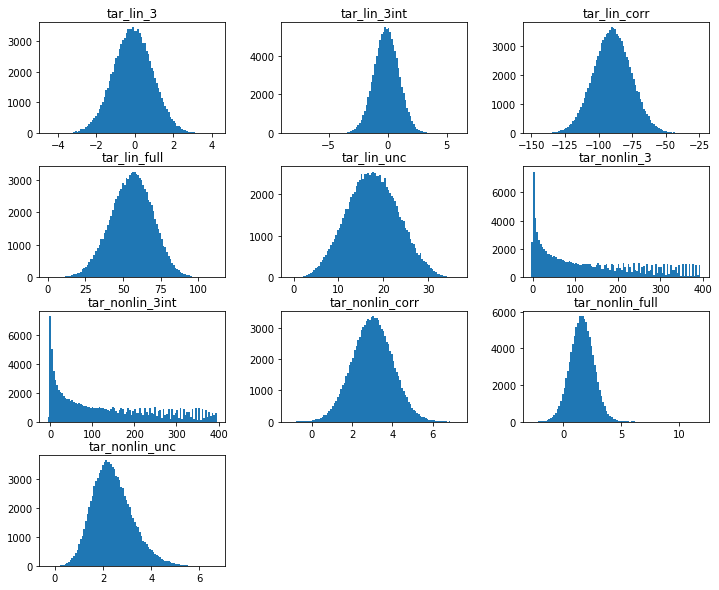

In [10]:
data[[col for col in data.columns if 'tar_' in col]].hist(bins=100, figsize=(12,10), grid=False)
plt.show()

In [11]:
data.to_csv('data/simulated/clean.csv', index=False)

In [18]:
coefs_total = z = {**coefs_linear, **coefs_nonlinear}

with open('data/simulated/coefficients.pkl', 'wb') as f:
    pickle.dump(coefs_total, f)

# Making dirty data

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
unc_normal_1               100000 non-null float64
unc_normal_2               100000 non-null float64
unc_skewed_pos             100000 non-null float64
unc_skewed_neg             100000 non-null float64
unc_binary                 100000 non-null int64
unc_categories_5           100000 non-null object
unc_categories_100         100000 non-null object
unc_ordinal                100000 non-null int64
corr_cat_1                 100000 non-null int64
corr_cat_2                 100000 non-null int64
corr_normal_by_cat         100000 non-null float64
corr_normal_by_2cats       100000 non-null float64
corr_multinormal_high_a    100000 non-null float64
corr_multinormal_high_b    100000 non-null float64
corr_multinormal_mid_a     100000 non-null float64
corr_multinormal_mid_b     100000 non-null float64
corr_multinormal_low_a     100000 non-null float64
corr_multinormal_low_b     100000

In [35]:
def dirtify(data):
    # do not add missing values to the targets
    df = data[[col for col in data.columns if 'tar_' not in col]].copy()
    n_entries = df.shape[0]
    np.random.seed(23)
    
    # adding random noise to some columns
    df['unc_normal_1'] += np.random.normal(loc=0, scale=0.5, size=n_entries) / 10
    df['corr_normal_by_cat'] += np.random.normal(loc=-0.5, scale=0.4, size=n_entries) / 10
    
    # make outliers
    random_entries = np.random.random(df.shape[0])<0.00001
    df['unc_normal_2'] = df['unc_normal_2'].mask(random_entries).fillna(df['unc_normal_2'] + 20)
    random_entries = np.random.random(df.shape[0])<0.00001
    df['corr_multinormal_mid_a'] = df['corr_multinormal_mid_a'].mask(random_entries).fillna(df['corr_multinormal_mid_a'] - 54)
    
    # adding 0.5% missing values
    missing = np.random.random(df.shape)<0.005
    df = df.mask(missing)
    
    # putting the targets back
    df = df.join(data[[col for col in data.columns if 'tar_' in col]])
    
    return df

In [36]:
data_dirty = dirtify(data)

data_dirty.head()

,unc_normal_1,unc_normal_2,unc_skewed_pos,unc_skewed_neg,unc_binary,unc_categories_5,unc_categories_100,unc_ordinal,corr_cat_1,corr_cat_2,corr_normal_by_cat,corr_normal_by_2cats,corr_multinormal_high_a,corr_multinormal_high_b,corr_multinormal_mid_a,corr_multinormal_mid_b,corr_multinormal_low_a,corr_multinormal_low_b,tar_lin_full,tar_lin_unc,tar_lin_corr,tar_lin_3,tar_lin_3int,tar_nonlin_full,tar_nonlin_unc,tar_nonlin_corr,tar_nonlin_3,tar_nonlin_3int
0,0.366843,9.046767,2.098417,29.620455,0.0,b,ljr,7.0,1.0,0.0,0.453842,0.351782,8.430675,-3.355695,25.236371,11.646659,-5.525505,4.621740,79.339121,17.975525,-98.029729,0.624460,0.002313,2.251485,2.000470,2.667974,2.450614,1.828467
1,0.014197,10.954762,2.895381,29.842289,1.0,a,vah,22.0,1.0,1.0,0.845540,-0.629935,3.334968,-0.792505,20.909618,11.555425,-5.988788,2.057060,49.482021,15.378844,-83.619765,0.297647,-0.993860,1.535575,2.395349,3.132021,19.756608,18.465101
2,-0.427691,9.986689,3.343133,29.393639,0.0,d,slv,81.0,1.0,0.0,1.193667,2.232988,3.895617,-1.586941,21.466997,11.038788,-5.470228,5.952688,64.436321,28.101300,-83.890220,0.281222,0.584477,0.731560,3.872721,3.349330,262.933200,263.236455
3,0.521749,10.710674,3.307999,28.968660,1.0,d,exm,95.0,0.0,1.0,0.071048,3.870697,8.248896,-3.246644,21.905036,9.963264,-5.431880,3.758482,69.456178,24.317470,-88.733443,0.771001,-0.325958,2.566616,3.447710,3.330483,361.716714,360.619755
4,0.385919,9.140127,1.827119,28.887216,0.0,d,jgc,29.0,0.0,1.0,-0.315196,4.352840,4.496770,-1.173505,17.377266,6.832519,-8.288617,3.684319,19.475321,20.812954,-68.675902,0.611498,1.680765,2.750494,2.395742,2.505630,34.408310,35.477577


In [37]:
data_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
unc_normal_1               99542 non-null float64
unc_normal_2               99507 non-null float64
unc_skewed_pos             99479 non-null float64
unc_skewed_neg             99520 non-null float64
unc_binary                 99481 non-null float64
unc_categories_5           99515 non-null object
unc_categories_100         99512 non-null object
unc_ordinal                99478 non-null float64
corr_cat_1                 99469 non-null float64
corr_cat_2                 99500 non-null float64
corr_normal_by_cat         99494 non-null float64
corr_normal_by_2cats       99499 non-null float64
corr_multinormal_high_a    99506 non-null float64
corr_multinormal_high_b    99483 non-null float64
corr_multinormal_mid_a     99545 non-null float64
corr_multinormal_mid_b     99489 non-null float64
corr_multinormal_low_a     99491 non-null float64
corr_multinormal_low_b     99494 non-null 

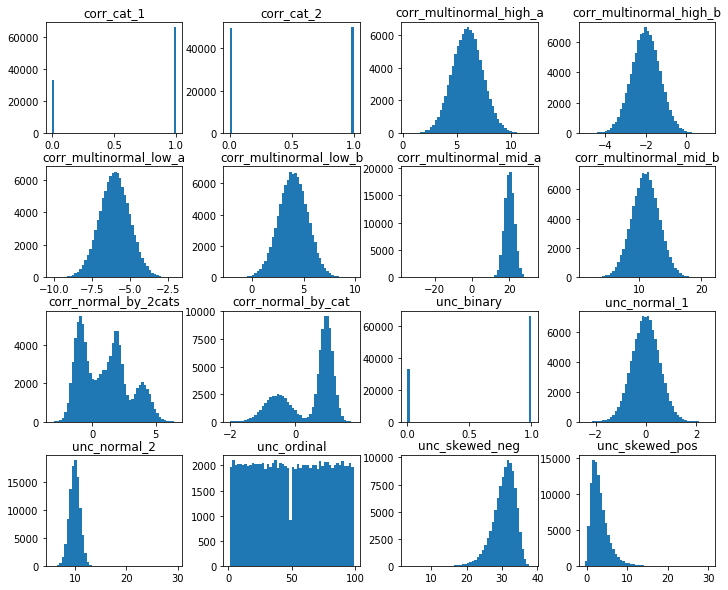

In [38]:
data_dirty[[col for col in data_dirty.columns if 'tar_' not in col]].hist(bins=50, figsize=(12,10), grid=False)
plt.show()

In [39]:
data_dirty.to_csv('data/simulated/dirty.csv', index=False)

# Exploration

Just focusing on the simplest targets for brevity

## Linear relations with and without interactions

In [17]:
coefs_linear['tar_lin_3']

,feat,coef
0,unc_normal_1,0.40
1,corr_normal_by_cat,-0.01
2,corr_multinormal_mid_a,0.03


tar_lin_3                  1.000000
unc_skewed_neg            -0.955904
unc_normal_1               0.195014
tar_nonlin_full            0.187491
corr_multinormal_mid_a     0.076997
tar_lin_full               0.047282
tar_lin_unc                0.035081
corr_multinormal_mid_b     0.033807
tar_lin_corr              -0.031970
tar_nonlin_unc             0.030820
tar_lin_3int              -0.027901
tar_nonlin_3               0.009548
corr_normal_by_2cats       0.006652
corr_normal_by_cat        -0.004832
corr_cat_2                -0.004560
unc_normal_2               0.004200
corr_cat_1                -0.003618
corr_multinormal_low_a    -0.002616
unc_skewed_pos             0.002183
unc_binary                 0.001987
corr_multinormal_high_a    0.001960
corr_multinormal_high_b   -0.001800
tar_nonlin_corr            0.001098
corr_multinormal_low_b    -0.000753
tar_nonlin_3int            0.000681
unc_ordinal                0.000066
Name: tar_lin_3, dtype: float64

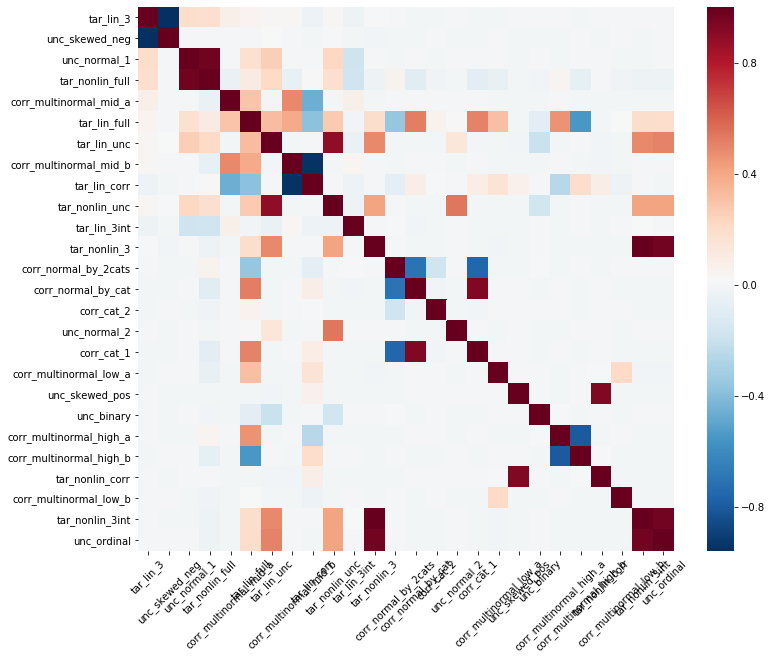

In [18]:
exp.plot_correlations(data, target='tar_lin_3')

                        unc_skewed_neg  unc_normal_1  corr_normal_by_cat  \
unc_skewed_neg                1.000000      0.001310           -0.001944   
unc_normal_1                  0.001310      1.000000            0.001915   
corr_normal_by_cat           -0.001944      0.001915            1.000000   
corr_multinormal_mid_a       -0.000356      0.001384            0.005066   
tar_lin_3                    -0.955904      0.195014           -0.004832   

                        corr_multinormal_mid_a  tar_lin_3  
unc_skewed_neg                       -0.000356  -0.955904  
unc_normal_1                          0.001384   0.195014  
corr_normal_by_cat                    0.005066  -0.004832  
corr_multinormal_mid_a                1.000000   0.076997  
tar_lin_3                             0.076997   1.000000  


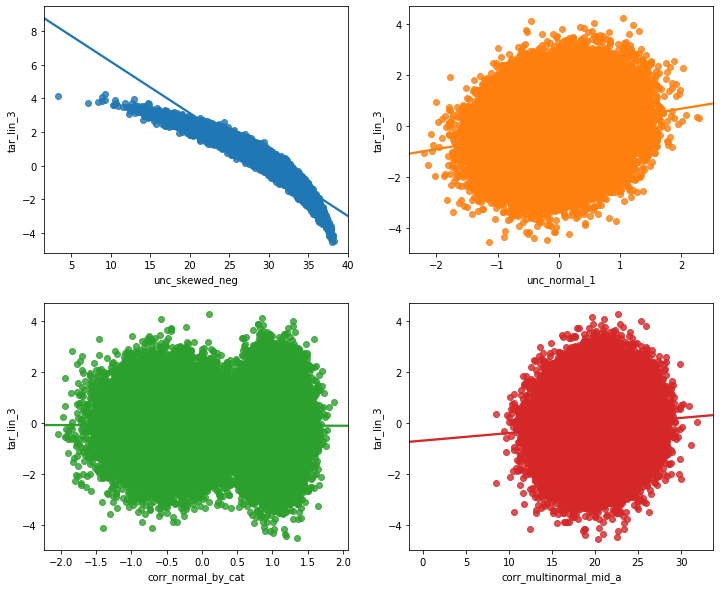

In [19]:
exp.corr_target(data, 'tar_lin_3', ['unc_skewed_neg', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

It is interesting to notice how `unc_skewed_neg` was not used to generate the target, it is completely uncorrelated with the features that generate the target, but it is so correlated with it. It will be even more interesting to check what happens when our ML models will focus on this feature rather than the truly important ones.

In [20]:
coefs_linear['tar_lin_3int']

,feat,coef
0,unc_normal_1,0.40
1,corr_normal_by_cat,-0.01
2,corr_multinormal_mid_a,0.03
3,unc_normal_1__corr_normal_by_cat,0.60
4,all_3,1.30


tar_lin_3int               1.000000
unc_normal_1              -0.178904
tar_nonlin_full           -0.174805
corr_multinormal_mid_a     0.075960
tar_lin_unc               -0.042922
corr_multinormal_mid_b     0.038567
tar_lin_corr              -0.036399
tar_nonlin_unc            -0.033222
tar_lin_3                 -0.027901
tar_nonlin_3int            0.014661
tar_lin_full              -0.014250
corr_normal_by_2cats       0.010654
corr_normal_by_cat        -0.008953
corr_cat_1                -0.008424
corr_cat_2                -0.006065
tar_nonlin_3               0.005449
unc_normal_2               0.004878
unc_ordinal                0.004731
corr_multinormal_low_a    -0.004521
tar_nonlin_corr           -0.004220
unc_skewed_pos            -0.004178
corr_multinormal_high_a   -0.003999
unc_skewed_neg            -0.001179
corr_multinormal_low_b     0.000843
unc_binary                -0.000842
corr_multinormal_high_b   -0.000072
Name: tar_lin_3int, dtype: float64

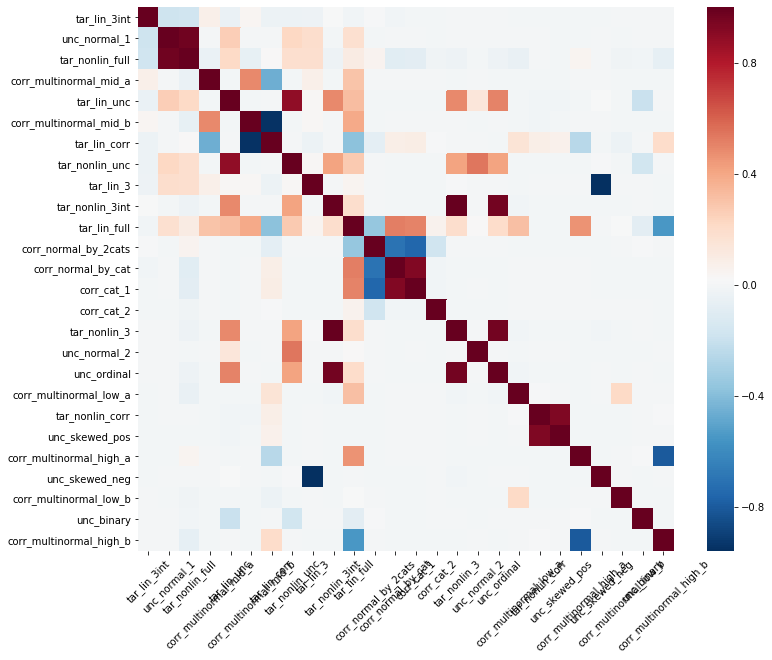

In [21]:
exp.plot_correlations(data, target='tar_lin_3int')

                        unc_normal_1  corr_normal_by_cat  \
unc_normal_1                1.000000            0.001915   
corr_normal_by_cat          0.001915            1.000000   
corr_multinormal_mid_a      0.001384            0.005066   
corr_multinormal_mid_b      0.001404            0.005021   
tar_lin_3int               -0.178904           -0.008953   

                        corr_multinormal_mid_a  corr_multinormal_mid_b  \
unc_normal_1                          0.001384                0.001404   
corr_normal_by_cat                    0.005066                0.005021   
corr_multinormal_mid_a                1.000000                0.492911   
corr_multinormal_mid_b                0.492911                1.000000   
tar_lin_3int                          0.075960                0.038567   

                        tar_lin_3int  
unc_normal_1               -0.178904  
corr_normal_by_cat         -0.008953  
corr_multinormal_mid_a      0.075960  
corr_multinormal_mid_b      0.038567  

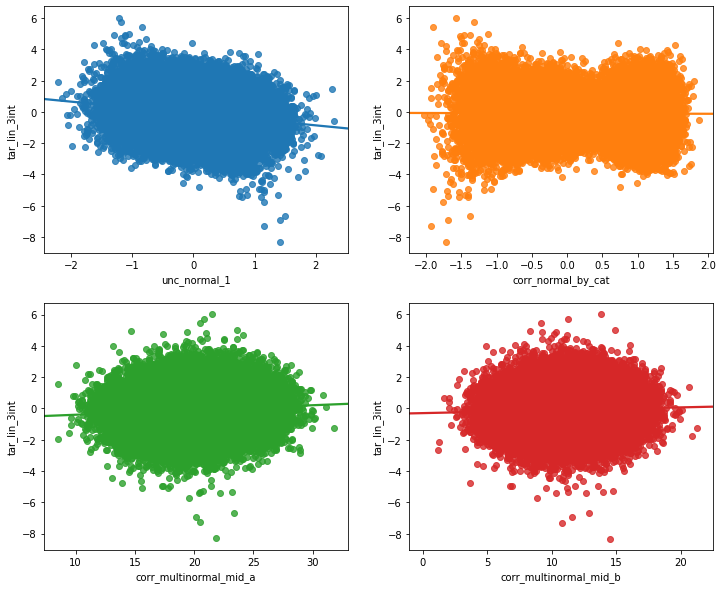

In [22]:
exp.corr_target(data, 'tar_lin_3int', ['unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a', 'corr_multinormal_mid_b'])

With the interactions, we lose the accidental correlation with a random variable and we are left with the more predictable situation: the 3 generating features and the one correlated with one of them.

## Non-linear relation with and without interactions

In [23]:
coefs_nonlinear['tar_nonlin_3']

,feat,coef
0,unc_normal_1_squared,0.04
1,corr_normal_by_cat,-0.09
2,corr_multinormal_mid_a_tanh,0.80


tar_nonlin_3               1.000000
tar_nonlin_3int            0.999920
unc_ordinal                0.968966
tar_lin_unc                0.490567
tar_nonlin_unc             0.412640
tar_lin_full               0.196243
tar_nonlin_full           -0.026223
unc_skewed_neg            -0.010000
tar_lin_3                  0.009548
corr_multinormal_low_a    -0.009418
tar_lin_3int               0.005449
corr_cat_2                -0.004789
corr_multinormal_low_b    -0.004765
corr_normal_by_cat        -0.004596
unc_normal_2               0.004576
tar_nonlin_corr           -0.004546
corr_multinormal_high_b   -0.003534
unc_skewed_pos            -0.003417
corr_cat_1                -0.003400
unc_binary                 0.003064
corr_normal_by_2cats       0.003037
corr_multinormal_mid_a    -0.002436
corr_multinormal_high_a   -0.002132
unc_normal_1               0.001818
tar_lin_corr              -0.000761
corr_multinormal_mid_b    -0.000745
Name: tar_nonlin_3, dtype: float64

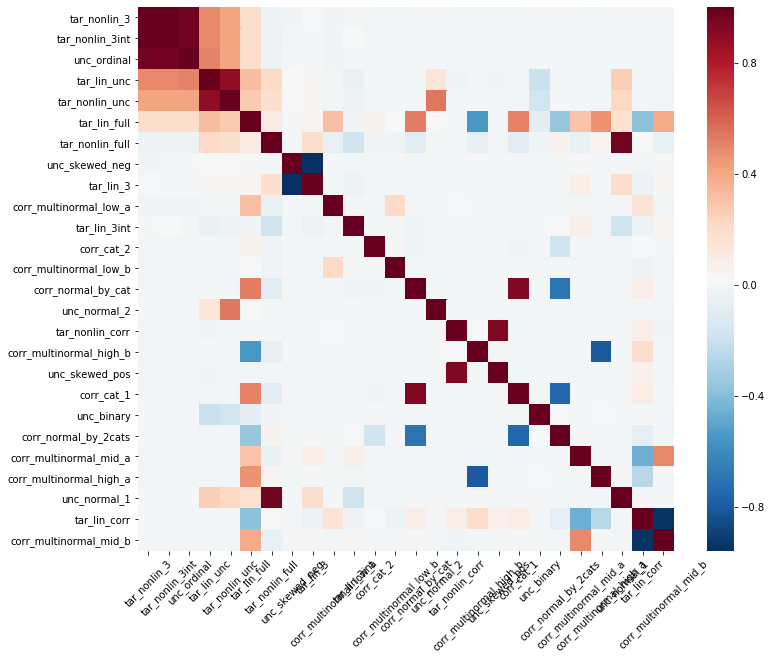

In [24]:
exp.plot_correlations(data, target='tar_nonlin_3')

                        unc_ordinal  unc_normal_1  corr_normal_by_cat  \
unc_ordinal                1.000000      0.001583           -0.004531   
unc_normal_1               0.001583      1.000000            0.001915   
corr_normal_by_cat        -0.004531      0.001915            1.000000   
corr_multinormal_mid_a    -0.003144      0.001384            0.005066   
tar_nonlin_3               0.968966      0.001818           -0.004596   

                        corr_multinormal_mid_a  tar_nonlin_3  
unc_ordinal                          -0.003144      0.968966  
unc_normal_1                          0.001384      0.001818  
corr_normal_by_cat                    0.005066     -0.004596  
corr_multinormal_mid_a                1.000000     -0.002436  
tar_nonlin_3                         -0.002436      1.000000  


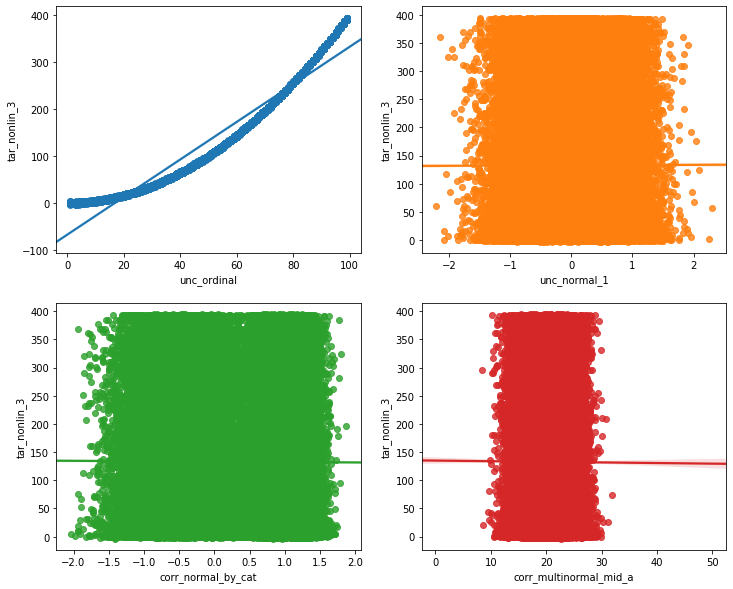

In [26]:
exp.corr_target(data, 'tar_nonlin_3', ['unc_ordinal', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

Again, an amazing accidental correlation and very weird patterns for the 3 generating features

In [27]:
coefs_nonlinear['tar_nonlin_3int']

,feat,coef
0,unc_normal_1_squared,0.04
1,corr_normal_by_cat,-0.09
2,corr_multinormal_mid_a_tanh,0.80
3,unc_normal_1__corr_normal_by_cat,0.60
4,all_3,-1.30


tar_nonlin_3int            1.000000
tar_nonlin_3               0.999920
unc_ordinal                0.968963
tar_lin_unc                0.489857
tar_nonlin_unc             0.412057
tar_lin_full               0.195698
tar_nonlin_full           -0.029406
tar_lin_3int               0.014661
corr_multinormal_low_a    -0.009436
corr_cat_2                -0.004804
corr_multinormal_low_b    -0.004751
corr_normal_by_cat        -0.004634
tar_nonlin_corr           -0.004593
unc_normal_2               0.004584
corr_multinormal_high_b   -0.003519
unc_skewed_pos            -0.003474
corr_cat_1                -0.003444
corr_normal_by_2cats       0.003076
unc_binary                 0.003039
corr_multinormal_mid_a    -0.002418
corr_multinormal_high_a   -0.002184
unc_skewed_neg            -0.001774
unc_normal_1              -0.001467
tar_lin_corr              -0.000812
corr_multinormal_mid_b    -0.000690
tar_lin_3                  0.000681
Name: tar_nonlin_3int, dtype: float64

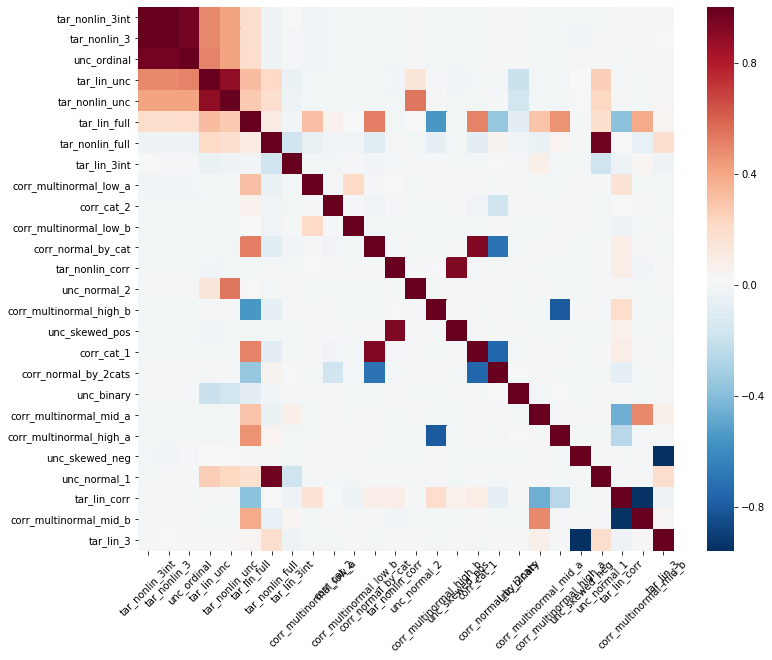

In [28]:
exp.plot_correlations(data, target='tar_nonlin_3int')

                        unc_ordinal  unc_normal_1  corr_normal_by_cat  \
unc_ordinal                1.000000      0.001583           -0.004531   
unc_normal_1               0.001583      1.000000            0.001915   
corr_normal_by_cat        -0.004531      0.001915            1.000000   
corr_multinormal_mid_a    -0.003144      0.001384            0.005066   
tar_nonlin_3int            0.968963     -0.001467           -0.004634   

                        corr_multinormal_mid_a  tar_nonlin_3int  
unc_ordinal                          -0.003144         0.968963  
unc_normal_1                          0.001384        -0.001467  
corr_normal_by_cat                    0.005066        -0.004634  
corr_multinormal_mid_a                1.000000        -0.002418  
tar_nonlin_3int                      -0.002418         1.000000  


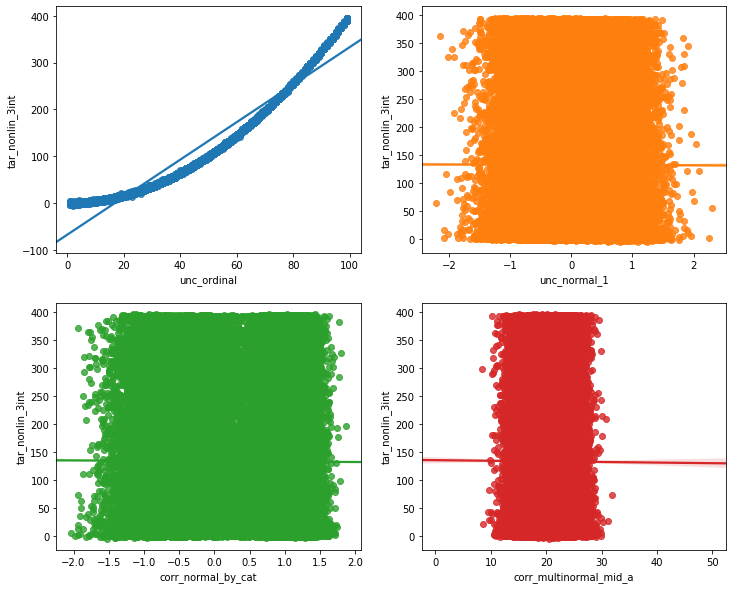

In [29]:
exp.corr_target(data, 'tar_nonlin_3int', ['unc_ordinal', 'unc_normal_1', 'corr_normal_by_cat', 'corr_multinormal_mid_a'])

This time, the weird correlation doesn't disappear. I can't wait to test some models in it.

The main lesson, however, is that we should use this kind of eda as a guide but not rely on it too much as it can mislead us in building models that do not make particular sense. We will explore this aspect in later kernels and move on with the experiment design.